# Evapotranspiración MODIS
_Autor:_    __Jesús Casado__ <br> _Revisión:_ __21/01/2020__ <br>

__Introducción__<br>
Datos de MODIS sobre NDVI y EVI en la cuenca del Deva.
1. Se cargan los datos originales (16 días) y se agregan a diversas frecuencias temporales (mensual y anual). Los datos se muestran en mapas y series.
2. Introducción al análisis de EOFs sobre los datos anteriores.

__Cosas que arreglar__ <br>
Cómo leer atributos del archivo _hdf_ de MODIS.

***

__Índice__ <br>
__[Datos](#Datos)__<br>
[DEM de la cuenca](#DEM-de-la-cuenca-(ETRS89-UTM30N))<br>
[NDVI MODIS](#NDVI-MODIS)<br>

__[Análisis](#Análisis)__<br>
[16 diario](#16-diario)<br>
[Mensual](#Mensual)<br>
[Anual](#Anual)<br>
[EOF](#EOF)<br>

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.gridspec import GridSpec
from netCDF4 import Dataset, num2date, date2num
#import h5py
from datetime import datetime
from calendar import monthrange
import time

import os
rutaBase = os.getcwd().replace('\\', '/') + '/'

import geopandas as gpd
import earthpy as et

from eofs.standard import Eof

import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
from pyproj import Proj, transform, CRS
os.environ['PROJ_LIB'] = r'C:\Anaconda3\pkgs\proj4-4.9.3-vc14_5\Library\share'

In [3]:
# import MODIS functions
os.chdir(rutaBase)
%run funciones_MODIS.ipynb
%run funciones_EOF.ipynb

***
## Datos
### DEM de la cuenca (ETRS89-UTM30N)

In [4]:
# cargar shapefile
rutaCarto = 'F:/OneDrive - Universidad de Cantabria/Cartografia/Politico/Espana/'
ESP = gpd.read_file(rutaCarto + 'Provincias_ETRS89_30N.shp')

# # gráfico
# fig, ax = plt.subplots(figsize=(6, 6))
# ESP.geometry.boundary.plot(ax=ax, edgecolor='grey', lw=.5);
# # tipo de datos
# type(ESP)
# # extensión espacial
# ESP.total_bounds
# # sistema de coordenadas
# ESP.crs
# # tipo de geometría
# ESP.geom_type.head()

In [5]:
rutaTETIS = 'F:/Proyectos/GESDIVAH/SDM/TETIS/PdE/Actual/'

dem = ascii2df(rutaTETIS + 'dem.asc')
XXdem = dem.columns
YYdem = dem.index

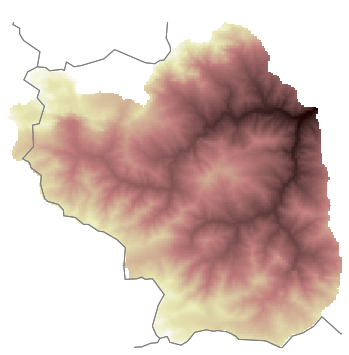

In [7]:
fig, ax = plt.subplots(figsize=(6, 6))
ESP.geometry.boundary.plot(ax=ax, edgecolor='gray', lw=1)
ax.imshow(dem, cmap='pink', extent=[XXdem[0], XXdem[-1], YYdem[-1], YYdem[0]])
ax.set(xlim=(XXdem[0], XXdem[-1]), ylim=(YYdem[-1], YYdem[0]))
# ax.axis('equal');
ax.set_title('DEM cuenca del DEVA-1265', fontsize=13, fontweight='bold')
ax.axis('off');

### Datos MODIS

In [18]:
rutaMODIS = 'F:/OneDrive - Universidad de Cantabria/Cartografia/MODIS/'
rutaMODIS = 'F:/OneDrive - Universidad de Cantabria/Cartografia/MODIS/'
#rutaExport = 'F:/Proyectos/GESDIVAH/SDM/Data/PdE/MODIS/'
rutaExport = rutaBase + '../output/VI/'
if os.path.exists(rutaExport) == False:
    os.makedirs(rutaExport)

In [10]:
products = {'Terra': 'MOD13A1', 'Aqua': 'MYD13A1'}
#var = '500m 16 days EVI'
var = '500m 16 days NDVI'
atributes = [2400, 2400, -1111950.519667, 5559752.598333, 0., 4447802.078667]
coordsOut = 'epsg:25830'
filename = 'MODIS_' + var + '.nc'

In [20]:
if filename not in os.listdir(rutaExport):
    
    ##########################
    ### CARGAR DATOS BRUTOS###
    ##########################

    # ascii con el que recortar los mapas
    clip = rutaTETIS + 'dem.asc'
    
    NDVI = {sat: {} for sat in products}
    for sat in products:
        product = products[sat]
        # dateslim = ['2002-01-01', '2003-12-31']
        atributes = [2400, 2400, -1111950.519667, 5559752.598333, 0., 4447802.078667]
        coordsOut = 'epsg:25830'

        MODIS_extract(rutaMODIS, product, var, atributes, factor=1e-8, dateslim=None, clip=clip,
                      coordsClip='epsg:25830')

        # extraer datos, coordenadas y fechas
        NDVI[sat]['NDVI'] = MODIS_extract.data
        NDVI[sat]['XX'] = MODIS_extract.Xcoords
        NDVI[sat]['YY'] = MODIS_extract.Ycoords
        NDVI[sat]['dates'] = MODIS_extract.dates
        

    ######################
    ### EXPORTAR DATOS ###
    ######################
    
    # definir el netcdf
    ncMODIS = Dataset(rutaExport + filename, 'w', format='NETCDF4')

    # crear grupos
    terra = ncMODIS.createGroup('Terra')
    aqua = ncMODIS.createGroup('Aqua')

    # crear atributos
    ncMODIS.description = 'Serie temporal de mapas de NDVI de la cuenca del Deva obtenidos a partir de MODIS'
    ncMODIS.history = 'Creado el ' + datetime.now().date().strftime('%Y-%m-%d')
    ncMODIS.source = 'https://e4ftl01.cr.usgs.gov/'
    ncMODIS.coordinateSystem = 'epsg:25830' # 'SINUSOIDAL'

    for group, sat, product in zip([terra, aqua], ['Terra', 'Aqua'], ['MOD16A2', 'MYD16A2']):
        # crear las dimensiones
        time = group.createDimension('time', len(NDVI[sat]['dates']))
        Y = group.createDimension('Y', NDVI[sat]['YY'].shape[0])
        X = group.createDimension('X', NDVI[sat]['YY'].shape[1])

        # crear variables
        ndvi = group.createVariable(product, 'f4', ('time', 'Y', 'X'))
        ndvi.units = '-'
        # print(NDVIa)
        times = group.createVariable('time', 'f8', ('time',))
        times.units = 'días desde el 0001-01-01'
        times.calendar = 'Gregoriano'
        Xs = group.createVariable('X', 'u4', ('X',))
        Xs.units = 'm'
        Ys = group.createVariable('Y', 'u4', ('Y',))
        Ys.units = 'm'

        # variable NDVI
        for ki in range(NDVI[sat]['NDVI'].shape[2]):
            ndvi[ki,:,:] = NDVI[sat]['NDVI'][:,:,ki]
        # variable 'time'
        deltas = [date - datetime(1, 1, 1).date() for date in NDVI[sat]['dates']]
        times[:] = [delta.days for delta in deltas]
        # variable 'X'
        x = NDVI[sat]['XX'].mean(axis=0)
        pos = int(len(x) / 2)
        cellsize = np.mean(x[1:] - x[:-1])
        Xs[:] = [x[pos] + (i - pos) * cellsize for i in range(len(x))]
        # variable 'Y'
        y = NDVI[sat]['YY'].mean(axis=1)
        pos = int(len(y) / 2)
        cellsize = np.mean(y[1:] - y[:-1])
        Ys[:] = [y[pos] + (i - pos) * cellsize for i in range(len(y))]

    ncMODIS.close()

nº filas:  48	nº columnas:  49
nº filas:  48	nº columnas:  49


In [20]:
###############################
### IMPORTAR DATOS TRATADOS ###
###############################

# Cargar netcdf con los datos MODIS
ncRead = Dataset(rutaExport + filename, 'r', format='NETCDF4')

# extraer datos en un diccionario
NDVI = {'Terra': {}, 'Aqua': {}}
for sat, product in zip(['Terra', 'Aqua'], ['MOD16A2', 'MYD16A2']):
    # evapotranspiración
    NDVI[sat]['NDVI'] = ncRead[sat][product][::]
    # fechas
    NDVI[sat]['dates'] = [datetime(1, 1, 1) + timedelta(time) for time in ncRead[sat]['time'][:]]
    # coordenadas
    NDVI[sat]['X'] = ncRead[sat]['X'][:]
    NDVI[sat]['Y'] = ncRead[sat]['Y'][:]

ncRead.close()

***
## Análisis
### 16 diario

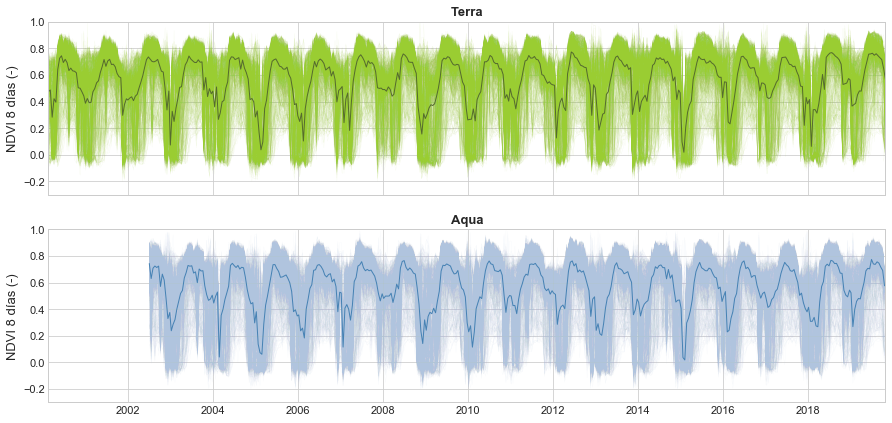

In [30]:
plotMODISseries(NDVI, 'NDVI', 'dates', r=.1, ymin=True, ylabel='NDVI 8 días (-)')
plt.savefig(rutaExport + 'NDVI serie 8 días.png', dpi=300, tight_layout=True)

### Mensual
__Medias mensuales__

In [27]:
def mediaMensual(dates, Data):
    """
    """
    
    # medias mensuales
    meanMData = np.zeros((12, Data.shape[1], Data.shape[2])) * np.nan
    for m, month in enumerate(range(1, 13)):
        ks = [k for k, date in enumerate(dates) if date.month == month]
        meanMData[m,:,:] = np.nanmean(Data[ks,:,:], axis=0)
        
    return meanMData

In [28]:
# generar medias mensuales de NDVI
for sat in NDVI:
    NDVI[sat]['meanMNDVI'] = mediaMensual(NDVI[sat]['dates'], NDVI[sat]['NDVI'])

C:\Anaconda3\envs\test\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


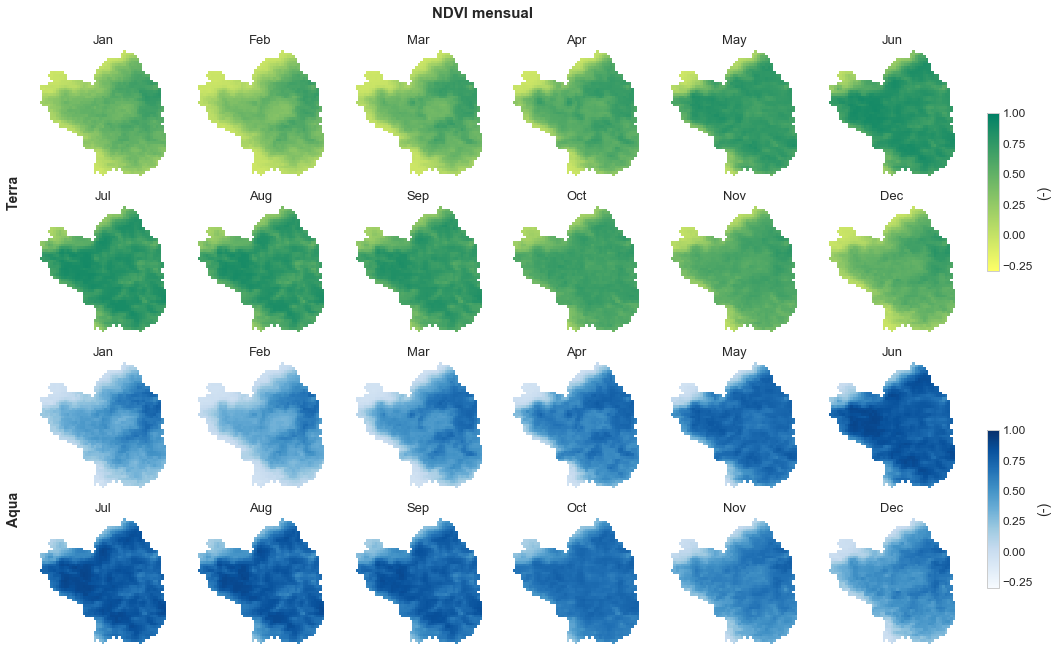

In [31]:
ncols = 6
nrows = int(np.ceil(12 / ncols)) * 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2.75*ncols, 2.75*nrows))
fig.subplots_adjust(right=0.9)

r = 1
vmin = -.3 #np.floor(min([np.nanmin(NDVI[sat]['meanMNDVI']) for sat in NDVI.keys()]) / r) * r
vmax = np.ceil(max([np.nanmax(NDVI[sat]['meanMNDVI']) for sat in NDVI.keys()]) / r) * r
cmaps = ['summer_r', 'Blues']

for s, (sat, cmap) in enumerate(zip(NDVI.keys(), cmaps)):
    for k, month in enumerate(range(1, 13)):
        f, c = int(k / ncols) + s * 2, k % ncols
        im = ax[f,c].imshow(NDVI[sat]['meanMNDVI'][k,:,:], cmap=cmap, vmin=vmin, vmax=vmax)
        ax[f,c].set_title(datetime(1900, month, 1).strftime('%b'), fontsize=13)
        ax[f,c].axis('off')
    
    cbar_ax = fig.add_axes([0.925, 0.6 - 0.4 * s, 0.01, 0.2])
    cbar_ax.tick_params(labelsize=12)
    cb = plt.colorbar(im, cax=cbar_ax, orientation='vertical')
    cb.set_label('(-)', fontsize=14)
    fig.text(0.1, 0.7  - 0.4 * s, sat, fontsize=14, fontweight='bold', rotation=90,
             verticalalignment='center')
fig.text(0.5, .92, 'NDVI mensual', fontsize=15, fontweight='bold', horizontalalignment='center');
plt.savefig(rutaExport + 'NDVI medias mensuales.png', dpi=300, tight_layout=True)

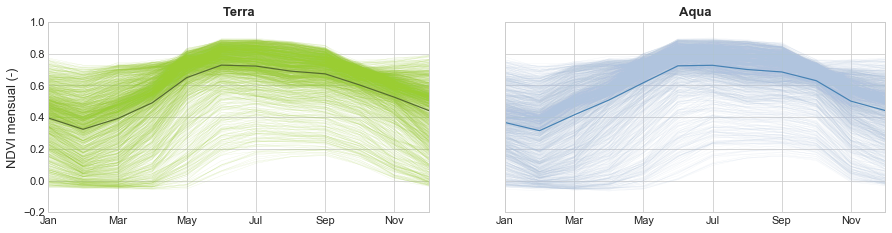

In [34]:
# mostrar la media mensual para cada celda y la media de la cuenca
fig, axes = plt.subplots(ncols=2, figsize=(15, 3.5), sharey=True)

r = .2
ymin = np.floor(min([np.nanmin(NDVI[sat]['meanMNDVI']) for sat in NDVI.keys()]) / r) * r
ymax = np.ceil(max([np.nanmax(NDVI[sat]['meanMNDVI']) for sat in NDVI.keys()]) / r) * r
colors = [['yellowgreen', 'darkolivegreen'], ['lightsteelblue', 'steelblue']]

for c, (ax, sat) in enumerate(zip(axes, NDVI.keys())):
    meanMNDVIx = NDVI[sat]['meanMNDVI']
    for i in range(meanMNDVIx.shape[1]):
        for j in range(meanMNDVIx.shape[2]):
            if np.isnan(meanMNDVIx[:,i,j]).sum() == meanMNDVIx.shape[0]: # celda vacía
                continue
            else:
                ax.plot(meanMNDVIx[:,i,j], lw=.25, c=colors[c][0], alpha=.25)
    ax.plot(np.nanmean(meanMNDVIx, axis=(1, 2)), c=colors[c][1], lw=1.2)
    ax.tick_params(labelsize=11)
    ax.set(xlim=(0, 11), ylim=(ymin, ymax))
    if c == 0:
        ax.set_ylabel('NDVI mensual (-)', fontsize=13);
    monthnames = [datetime(1900, m, 1).strftime('%b') for m in range(1, 13)]
    ax.set_xticklabels(monthnames[::2])
    ax.set_title(sat, fontsize=13, fontweight='bold')
plt.savefig(rutaExport + 'NDVI serie medias mensuales.png', dpi=300, tight_layout=True)

#### Serie mensual

In [35]:
def serieMensual(dates, Data, agg='mean'):
    """
    """
    
    start = datetime(dates[0].year, dates[0].month, 1).date()
    end = dates[-1] + timedelta(8)
    end = datetime(end.year, end.month, monthrange(end.year, end.month)[1]).date()
    days = pd.date_range(start, end)
    months = pd.date_range(start, end, freq='M')
    len(days), len(months)

    # serie mensuales
    serieMData = np.zeros((len(months), Data.shape[1], Data.shape[2])) * np.nan
    for i in range(Data.shape[1]):
        for j in range(Data.shape[2]):
            print('celda {0:>5} de {1:>5}'.format(i * Data.shape[2] + j + 1,
                                                  Data.shape[1] * Data.shape[2]), end='\r')
            if np.isnan(Data[:,i,j]).sum() == Data.shape[0]: # ningún dato en toda la serie
                continue
            else:
                # generar serie diaria
                auxd = pd.Series(index=days)
                for k, (st, et) in enumerate(zip(dates, Data[:,i,j])):
                    if np.isnan(et):
                        continue
                    else:
                        if st != dates[-1]:
                            en = dates[k+1]
                        else:
                            en = st + timedelta(8)
                        if agg == 'sum':
                            auxd[st:en - timedelta(1)] = et / (en - st).days
                        elif agg == 'mean':
                            auxd[st:en - timedelta(1)] = et
                # generar serie mensual
                if agg == 'sum':
                    auxm = auxd.groupby([auxd.index.year, auxd.index.month]).agg(np.nansum)
                elif agg == 'mean':
                    auxm = auxd.groupby([auxd.index.year, auxd.index.month]).agg(np.nanmean)
                auxm.index = [datetime(idx[0], idx[1], monthrange(idx[0], idx[1])[1]).date() for idx in auxm.index]
                # asignar serie mensual a su celda en el array 3D
                serieMData[:,i,j] = auxm.iloc[:serieMData.shape[0]].copy()
                del auxd, auxm
    return serieMData, months

In [36]:
# generar series de NDVI mensual
for sat in NDVI:
    NDVI[sat]['serieMNDVI'], NDVI[sat]['months'] = serieMensual(NDVI[sat]['dates'], NDVI[sat]['NDVI'],
                                                             agg='mean')

C:\Anaconda3\envs\test\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice


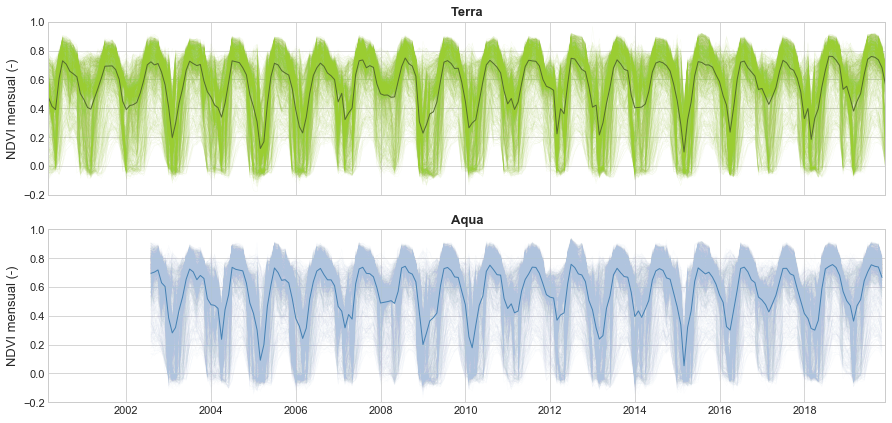

In [38]:
plotMODISseries(NDVI, 'serieMNDVI', 'months', r=.2, ymin=True, ylabel='NDVI mensual (-)')
plt.savefig(rutaExport + 'NDVI serie mensual.png', dpi=300, tight_layout=True)

### Anual
__Media anual__

In [39]:
for sat in NDVI:
    NDVI[sat]['meanANDVI'] = np.nanmean(NDVI[sat]['NDVI'], axis=0)

C:\Anaconda3\envs\test\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


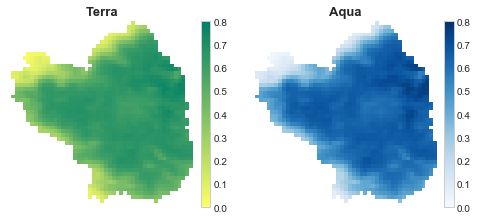

In [43]:
# mapa de NDVI media anual
fig, axes = plt.subplots(ncols=2, figsize=(8, 4))

r = .1
vmin = np.floor(min([np.nanmin(NDVI[sat]['meanANDVI']) for sat in NDVI.keys()]) / r) * r
vmax = np.ceil(max([np.nanmax(NDVI[sat]['meanANDVI']) for sat in NDVI.keys()]) / r) * r

cmaps = ['summer_r', 'Blues']

for c, (ax, sat) in enumerate(zip(axes, NDVI.keys())):
    im = ax.imshow(NDVI[sat]['meanANDVI'], cmap=cmaps[c], vmin=vmin, vmax=vmax)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    ax.set_title(sat, fontsize=13, fontweight='bold')
    ax.axis('off');
plt.savefig(rutaExport + 'NDVI mapa media anual.png', dpi=300, tight_layout=True)

__Serie anual__

In [44]:
def serieAnual(dates, Data, agg='mean', thr=40):
    
    # años con datos suficientes
    years = np.unique(np.array([date.year for date in dates]))
    ksyear = {}
    for year in years:
        ks = [k for k, date in enumerate(dates) if date.year == year]
        if len(ks) < thr: # si faltan excesivos mapas en el año
            years = years[years != year]
            continue
        else:
            ksyear[year] = ks

    # medias anuales        
    serieAData = np.zeros((len(years), Data.shape[1], Data.shape[2])) * np.nan
    for y, year in enumerate(years):
        if agg == 'mean':
            serieAData[y,:,:] = np.nanmean(Data[ksyear[year],:,:], axis=0)
        if agg == 'sum':
            serieAData[y,:,:] = np.nanmean(Data[ksyear[year],:,:], axis=0) * 365 / 8
        
    return serieAData, years

In [45]:
# generar series de NDVI anual
for sat in NDVI:
    NDVI[sat]['serieANDVI'], NDVI[sat]['years'] = serieAnual(NDVI[sat]['dates'], NDVI[sat]['NDVI'], agg='mean', thr=20)

C:\Anaconda3\envs\test\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice


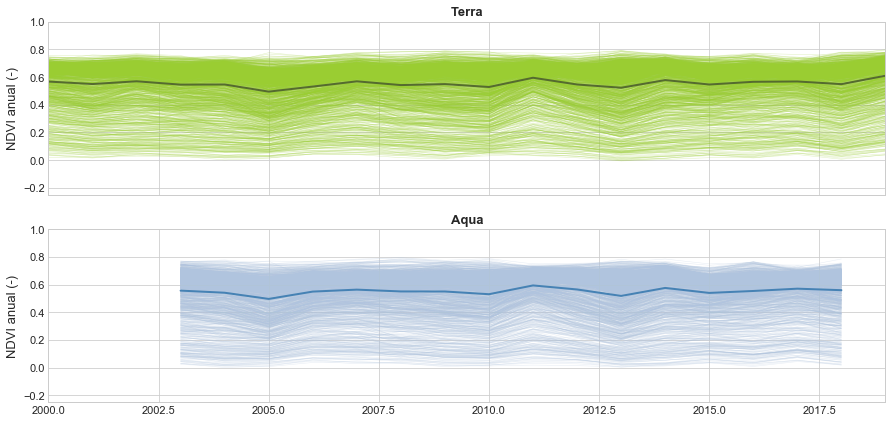

In [48]:
plotMODISseries(NDVI, 'serieANDVI', 'years', r=.25, ymin=True, ylabel='NDVI anual (-)', lw=.5, alpha=.3)
plt.savefig(rutaExport + 'NDVI serie anual.png', dpi=300, tight_layout=True)

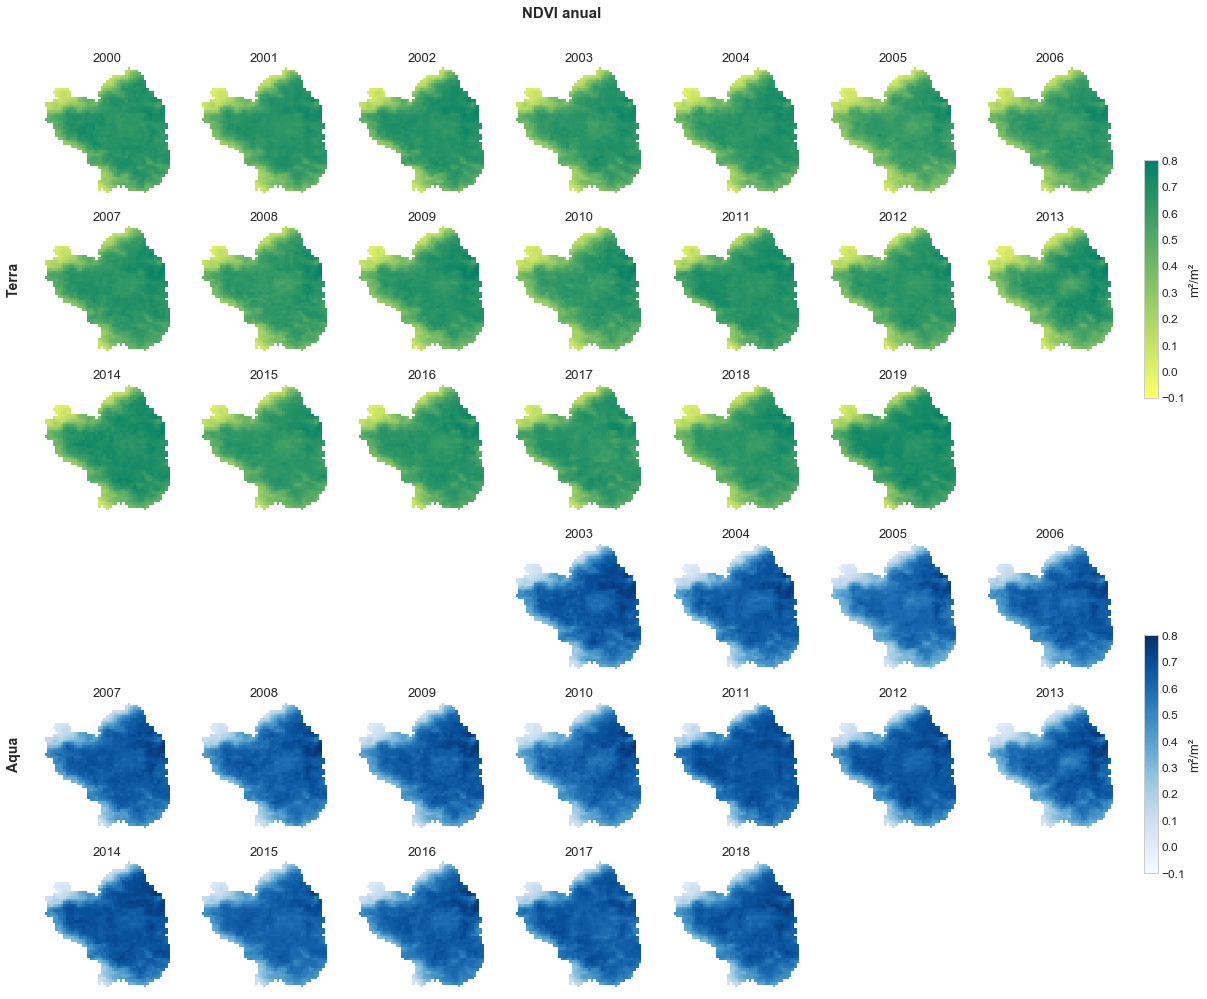

In [50]:
ymin = min([np.min(NDVI[sat]['years']) for sat in NDVI.keys()])
ymax = max([np.max(NDVI[sat]['years']) for sat in NDVI.keys()])
years = np.arange(ymin, ymax + 1)

ncols = 7
nrows = int(np.ceil(len(years) / ncols)) * 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2.75*ncols, 2.75*nrows))
fig.subplots_adjust(bottom=0.1)

r = .1
vmin = np.floor(min([np.nanmin(NDVI[sat]['serieANDVI']) for sat in NDVI.keys()]) / r) * r
vmax = np.ceil(max([np.nanmax(NDVI[sat]['serieANDVI']) for sat in NDVI.keys()]) / r) * r
cmaps = ['summer_r', 'Blues']

for s, (sat, cmap) in enumerate(zip(NDVI.keys(), cmaps)):
    for y, year in enumerate(years):
        f, c = int(y / ncols + s * (nrows / 2)), y % ncols
        if year in NDVI[sat]['years']:
            k = np.where(year == NDVI[sat]['years'])[0][0]
            im = ax[f,c].imshow(NDVI[sat]['serieANDVI'][k,:,:], cmap=cmap, vmin=vmin, vmax=vmax)
            ax[f,c].set_title(year, fontsize=13)
            ax[f,c].axis('off')
        else:
            ax[f,c].axis('off')
        if c < ncols - 1:
            for c in range(c+1, ncols):
                ax[f,c].axis('off')
            
    
    cbar_ax = fig.add_axes([0.92, 0.6  - .4 * s, 0.01, 0.2])
    cbar_ax.tick_params(labelsize=12)
    cb = plt.colorbar(im, cax=cbar_ax, orientation='vertical')
    cb.set_label('m²/m²', fontsize=13)
    fig.text(.1, .7 - .4 * s, sat, fontsize=14, fontweight='bold', rotation=90,
             verticalalignment='center')
fig.text(.5, .92, 'NDVI anual', fontsize=15, fontweight='bold',
         horizontalalignment='center');
plt.savefig(rutaExport + 'NDVI mapas anuales.png', dpi=300, tight_layout=True)

### EOF
#### Terra

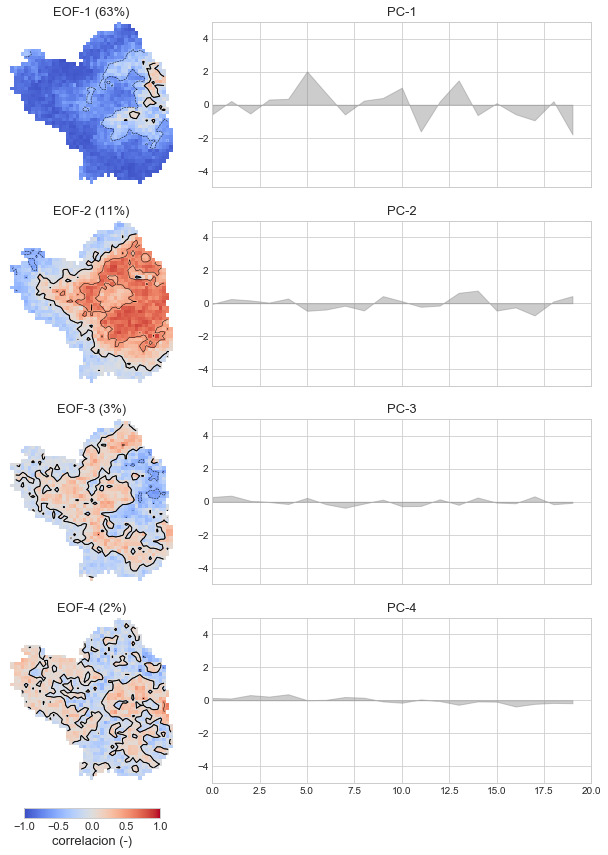

In [51]:
eofMODIS(NDVI['Terra']['serieANDVI'], NDVI['Terra']['Y'], nmodes=4, coordsIn='epsg:25830',
         lons=NDVI['Terra']['X'], plot='corr', normPCs=False, rserie=5)

eofs = eofMODIS.eofs
pcs = eofMODIS.pcs
corr = eofMODIS.correlation
var = eofMODIS.explainedVariance
plt.savefig(rutaExport + 'NDVI eofs-Terra anual.png', dpi=300, tight_layout=True)

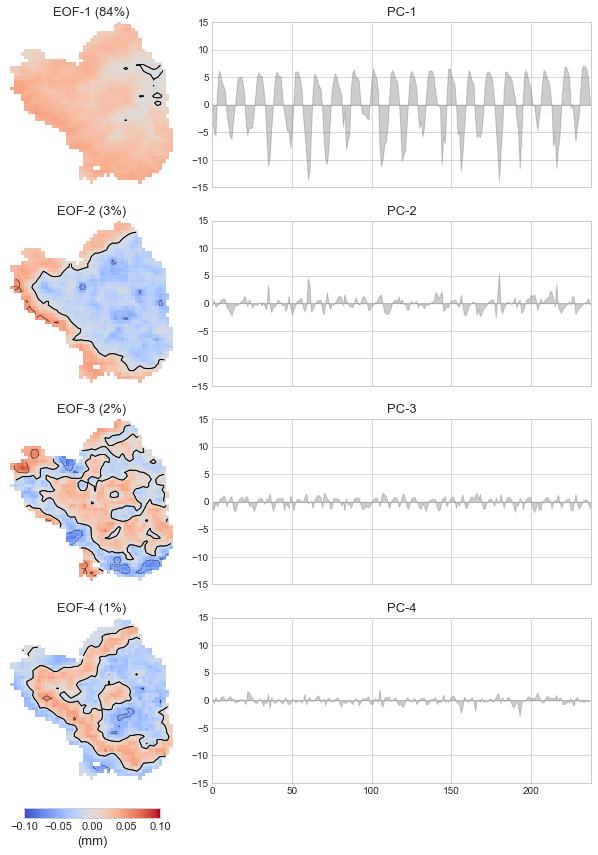

In [52]:
eofMODIS(NDVI['Terra']['serieMNDVI'], NDVI['Terra']['Y'], nmodes=4, coordsIn='epsg:25830',
         lons=NDVI['Terra']['X'], plot='eofs', normPCs=False, rserie=5)

eofs = eofMODIS.eofs
pcs = eofMODIS.pcs
corr = eofMODIS.correlation
var = eofMODIS.explainedVariance
plt.savefig(rutaExport + 'NDVI eofs-Terra mensual.png', dpi=300, tight_layout=True)

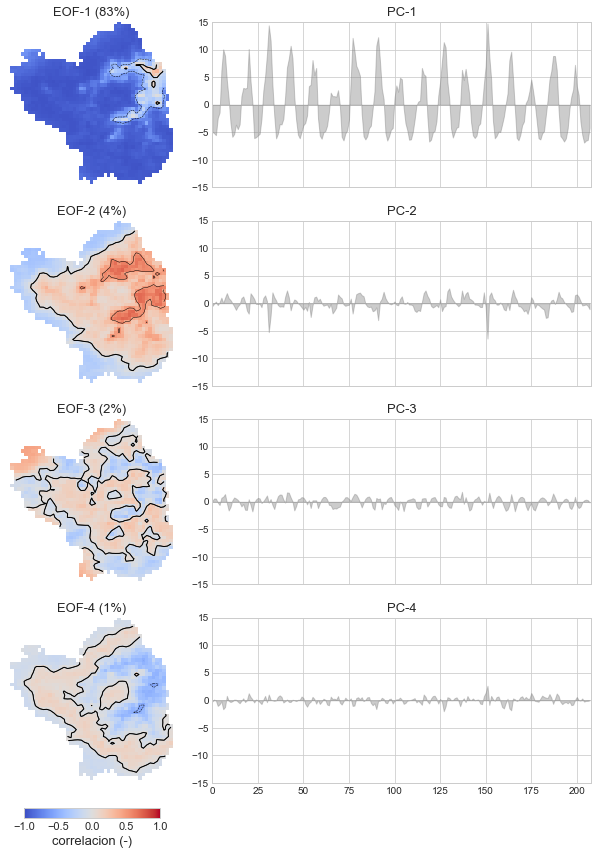

In [66]:
eofMODIS(NDVI['Aqua']['serieMNDVI'][:-1,:,:], NDVI['Aqua']['Y'], nmodes=4, coordsIn='epsg:25830',
         lons=NDVI['Aqua']['X'], plot='corr', normPCs=False, rserie=5)

eofs = eofMODIS.eofs
pcs = eofMODIS.pcs
corr = eofMODIS.correlation
var = eofMODIS.explainedVariance
plt.savefig(rutaExport + 'NDVI eofs-Aqua mensual.png', dpi=300, tight_layout=True)

In [ ]:
# At · A = Lambda
AtA = np.matrix(pcs) * np.matrix(np.transpose(pcs))
Lambda = np.diag(lambdas)

In [ ]:
reconstructed_data = solver.reconstructedField(4)
pseudo_pcs = solver.projectField(other_field)

In [ ]:
# 'SOLVERS' multivariable
from eofs.multivariate.standard import MultivariateEof
msolver = MultivariateEof([data1, data2, data3])
eofs_data1, eofs_data2, eofs_data3 = msolver.eofs()
pcs = msolver.pcs()